In [1]:
# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Common imports and settings
import os, sys
os.environ['USE_PYGEOS'] = '0'
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr

# Datacube
import datacube
from datacube.utils.rio import configure_s3_access
from datacube.utils import masking
from datacube.utils.cog import write_cog
# https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools
from dea_tools.plotting import display_map, rgb
from dea_tools.datahandling import mostcommon_crs

# EASI defaults
easinotebooksrepo = '/home/jovyan/easi-notebooks'
if easinotebooksrepo not in sys.path: sys.path.append(easinotebooksrepo)
from easi_tools import EasiDefaults, xarray_object_size, notebook_utils

In [ ]:
## tham số cần thay đổi
start_time = ""

In [2]:
# Data tools
import numpy as np
from datetime import datetime

# Datacube
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool   # https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_masking.py
from odc.algo import xr_reproject   # https://github.com/opendatacube/odc-algo/blob/main/odc/algo/_warp.py
from datacube.utils.geometry import GeoBox, box  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/geometry/_base.py

# Holoviews, Datashader and Bokeh
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# import geoviews as gv
# from holoviews.operation.datashader import rasterize
hv.extension('bokeh', logo=False)

In [3]:
# Dask gateway

cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
client

An existing cluster was found. Connecting to: easihub.da3c0b08317f4ce08e2911d18e7ba284


<Client: 'tls://10.0.60.217:8786' processes=1 threads=8, memory=28.00 GiB>

In [4]:
# from dask_gateway import Gateway
# gateway = Gateway()
# gateway.cluster_options()

In [5]:
dc = datacube.Datacube()

# Access AWS "requester-pays" buckets
# This is necessary for reading data from most third-party AWS S3 buckets such as for Landsat and Sentinel-2
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

In [6]:
from utils import load_data_geo
train_path = "train/Soc Trang_Traning.shp"
train = load_data_geo(train_path)
train.head()

Name                        geometry
0  Water1  POINT (620223.628 1072681.101)
1  Water1  POINT (621057.521 1071074.602)
2  Water1  POINT (621891.602 1069430.621)
3  Water1  POINT (622762.564 1068048.689)
4  Water1  POINT (623256.484 1066777.765)

In [7]:
from deafrica_tools.bandindices import calculate_indices
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Vietnam
min_longitude, max_longitude = (105.5, 106.4)
min_latitude, max_latitude = (9.2, 10.0)
min_date = '2021-12-01' # Start time
max_date = '2022-12-01' # End time
product = 's2_l2a'

query1 = {
    'product': product,                     # Product name
    'x': (min_longitude, max_longitude),    # "x" axis bounds
    'y': (min_latitude, max_latitude),      # "y" axis bounds
    'time': (min_date, max_date),           # Any parsable date strings
}

# Most common CRS
native_crs = notebook_utils.mostcommon_crs(dc, query1)

query1.update({
    'measurements': ['blue', 'green', 'red', 'nir', 'scl'],  # Selected measurement bands
    'output_crs': native_crs,               # EPSG code
    'resolution': (-10, 10),                # Target resolution
    'group_by': 'solar_day',                # Scene ordering
    'dask_chunks': {'x': 3310, 'y': 3000},  # Dask chunks
})

In [8]:
# Load data
data = dc.load(**query1)

notebook_utils.heading(notebook_utils.xarray_object_size(data))
display(data)

# Calculate valid (not nodata) masks for each layer
valid_mask = masking.valid_data_mask(data)
notebook_utils.heading('Valid data masks for each variable')
display(valid_mask)

<xarray.Dataset>
Dimensions:      (time: 143, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2021-12-01T03:35:07.305000 ... 2022-12...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

<xarray.Dataset>
Dimensions:      (time: 143, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2021-12-01T03:35:07.305000 ... 2022-12...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) bool dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    green        (time, y, x) bool dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    red          (time, y, x) bool dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    nir          (time, y, x) bool dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    scl          (time, y, x) bool dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>

In [9]:
# Get the scale factor and offset from the measurement metadata

measurement_info = dc.list_measurements().loc[query1['product']].loc[query1['measurements']]  # Pandas dataframe
display(measurement_info)

# The "SCL" band contains quality flags and information. The details can also be found in the metadata.

flag_name = 'scl'
flag_desc = masking.describe_variable_flags(data[flag_name])  # Pandas dataframe
display(flag_desc)
display(flag_desc.loc['qa'].values[1])

name   dtype units  nodata  \
measurement                                
blue          blue  uint16     1       0   
green        green  uint16     1       0   
red            red  uint16     1       0   
nir            nir  uint16     1       0   
scl            scl   uint8     1       0   

                                              flags_definition  \
measurement                                                      
blue                                                       NaN   
green                                                      NaN   
red                                                        NaN   
nir                                                        NaN   
scl          {'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'val...   

                           aliases  add_offset  scale_factor  
measurement                                                   
blue                [band_02, B02]        -0.1        0.0001  
green               [band_03, B03]        -0.1        0.0001  
red                 [band_04, B04]        -0.1        0.0001  
nir          [band_08, B08, nir_1]        -0.1        0.0001  
scl                [SCL, mask, qa]         NaN           NaN

bits  \
qa  [0, 1, 2, 3, 4, 5, 6, 7]   

                                               values  \
qa  {'0': 'no data', '1': 'saturated or defective'...   

                     description  
qa  Sen2Cor Scene Classification

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

In [10]:
# Create a "data quality" Mask layer

flags_def = flag_desc.loc['qa'].values[1]
good_pixel_flags = [flags_def[str(i)] for i in [4, 5]]  # To pass strings to enum_to_bool()

# enum_to_bool calculates the pixel-wise "or" of each set of pixels given by good_pixel_flags
# 1 = good data
# 0 = "bad" data

good_pixel_mask = enum_to_bool(data[flag_name], good_pixel_flags)  # -> DataArray
# display(good_pixel_mask)  # Type: bool

In [11]:
# Apply valid mask (calculated above) and good pixel mask with scale and offset for each data layer and merge the results
# Optional - use .persist() on each layer or the result dataset

scale = 0.0001
offset = 0  # Assumes earthsearch:boa_offset_applied = True (else offset = -0.1)

data_layer_names = [x for x in data.data_vars if x != 'scl']

rs = []
for layer_name in data_layer_names:
    # Apply valid mask (calculated above) and good pixel mask with scale and offset
    layer = data[[layer_name]].where(valid_mask[layer_name] & good_pixel_mask) * scale
    rs.append(layer)
    
result = xr.merge(rs).persist()  # Calculate intermediate result
result  # Type: float32

<xarray.Dataset>
Dimensions:      (time: 143, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2021-12-01T03:35:07.305000 ... 2022-12...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 3000, 3310), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [12]:
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
average_ndvi = ndvi.resample(time='1M').mean().persist()  ## tính mean cho từng tháng -> time = 12
average_ndvi  # DataArray

<xarray.DataArray 'NDVI' (time: 13, y: 8874, x: 9902)>
dask.array<stack, shape=(13, 8874, 9902), dtype=float32, chunksize=(1, 3000, 3310), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2021-12-31 2022-01-31 ... 2022-12-31

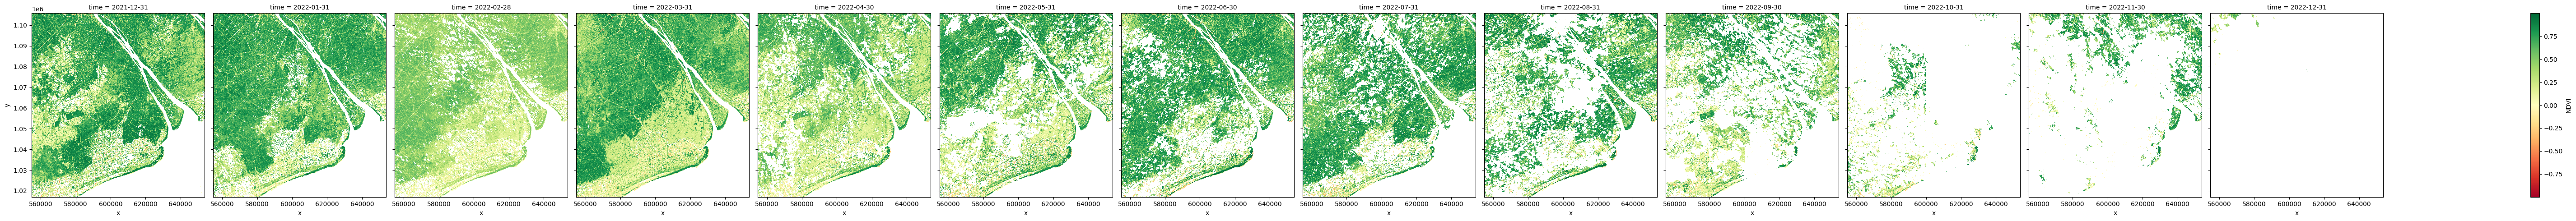

In [13]:
# average_ndvi.plot(col="time", size=5, clim=(0,1), cmap="RdYlGn")

In [ ]:
# An interactive holoviz plot
# Works for large datasets with dask
# An image of the data is created on-demand (see https://datashader.org/getting_started/Pipeline.html)
# xx = ndvi.to_dataset().hvplot(
#     groupby='time',rasterize=True,
#     cmap="RdYlGn", clim=(0,1),
#     height=500,
# )
# xx

In [13]:
average_ndvi = average_ndvi.fillna(average_ndvi.mean()).persist()

In [14]:
## load vh vv
import dask.array as da
import rasterio
import os
import rioxarray

VH_file = "Sen1_VH_10.21-10.22_update_new.tif"
VV_file = "Sen1_VV_10.21-10.22_update.tif"


In [15]:
# dsvv = rioxarray.open_rasterio(VV_file, chunks={'band': 1, 'x': 3310, 'y': 3000}, lock=False)
# dsvh = rioxarray.open_rasterio(VH_file, chunks={'band': 1, 'x': 3310, 'y': 3000}, lock=False)
dsvv = rioxarray.open_rasterio(VV_file)
dsvh = rioxarray.open_rasterio(VH_file)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [16]:
dsvv = dsvv.rename({"band": "time"})
dsvh = dsvh.rename({"band": "time"})

In [17]:
average_ndvi = average_ndvi.compute()

In [18]:
tmp = average_ndvi

In [19]:
tmp["time"] = dsvv.time
tmp["x"] = dsvv.x
tmp["y"] = dsvv.y

In [20]:
final_array = xr.concat([dsvh, dsvv], dim='time')

In [21]:
final_array = xr.concat([tmp, final_array], dim='time')

In [22]:
loaded_datasets = {}
for idx, point in train.iterrows():
    key = f"point_{idx + 1}"
    try:
        loaded_datasets[key] = {
            "NDVI": final_array.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').values,
            "label": point.Name
                               }
    except Exception as e:
        # loaded_datasets[key] = None
        print(e)
        break

In [23]:
label_encoder = LabelEncoder()

# Fit and transform the labels
labels = train.Name.values
numeric_labels = label_encoder.fit_transform(labels)
label_mapping = dict(zip(labels, numeric_labels))

In [24]:
X = []
for k, v in loaded_datasets.items():
    X.append(v)

In [25]:
x_new = []
lb_new = []
for i in range(len(X)):
    if X[i] is not None:
        x_new.append(X[i]["NDVI"])
        lb_new.append(numeric_labels[i])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x_new, lb_new, test_size=0.3, random_state=42)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Tạo RandomForestClassifier mặc định để sử dụng làm mô hình ban đầu trong pipeline
base_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Tạo pipeline
pipeline = Pipeline([
    # ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', base_model),
])
# Thiết lập các tham số bạn muốn tối ưu hóa
param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [6, 8, 10, 15, 20],
    'classifier__criterion': ['gini', 'entropy'],
}

# Sử dụng GridSearchCV để tìm bộ tham số tốt nhất
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
# In ra bộ tham số tốt nhất
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
# Dự đoán trên tập kiểm tra
y_pred = grid_search.predict(X_test)
# Đánh giá kết quả
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__n_estimators': 300}
Accuracy: 0.740506329113924


In [28]:
# average_ndvi = average_ndvi.persist()

In [29]:
# flattened_data = average_ndvi.stack(flattened=('x', 'y')).transpose('flattened', 'time')

In [30]:
result1 = []
for i in range(final_array.shape[1]):
    result1.extend(final_array.isel(y=i).values.T)
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000


In [31]:
# num_chunks = 5
# chunk_size = len(flattened_data['flattened']) // num_chunks
# split_data = flattened_data.chunk({'flattened': chunk_size})

In [32]:
num_parts = 16
split_arrays = np.array_split(result1, num_parts, axis=0)

In [33]:
import time
t = time.time()
y_pred = []
# with joblib.parallel_backend('dask'):
# for i in range(num_chunks + 1):
    # tmp = grid_search.predict(split_data.isel(flattened=slice(i * chunk_size, (i + 1) * chunk_size)))
for d in split_arrays:
    tmp = grid_search.predict(d)
    y_pred.append(tmp)
    print(f"{time.time() - t}")
    t = time.time()

29.342758655548096
30.90173649787903
29.350740909576416
29.047697067260742
28.92090940475464
29.135956525802612
29.310139417648315
29.11028742790222
29.32950448989868
29.450054168701172
29.27794313430786
29.48336410522461
29.536877870559692
29.227633237838745
29.213799476623535
29.262253284454346


In [34]:
final_label = y_pred[0]
for i in y_pred[1:]:
    final_label = np.concatenate((final_label, i), axis=0)

In [35]:
final_label = final_label.reshape(final_array.y.shape[0], final_array.x.shape[0])

In [36]:
from shapely.geometry import Point, Polygon
from pyproj import CRS
import rioxarray

final_xarray_save = xr.DataArray(final_label, dims=("y", "x"))

In [37]:
final_xarray_save = final_xarray_save.rio.write_crs(data.rio.crs)

In [38]:
x_values = final_array.x.values
y_values = final_array.y.values

data_array = xr.DataArray(final_xarray_save,
                          coords={'x': x_values, 'y': y_values},
                          dims=['y', 'x'])


In [39]:
data_array = data_array.rio.write_crs(final_array.rio.crs)

In [40]:
from shapely.geometry import Point, Polygon
## path predict region
region_path = "region/ST_region.shp" 

gdf = load_data_geo(region_path)
gdf = gdf.to_crs(average_ndvi.rio.crs)
polygon_coords = list(gdf.geometry.values[0].exterior.coords)
polygon_coordinates = [(x, y) for x, y, _ in polygon_coords]

geometries = [
    {
        'type': 'Polygon',
        'coordinates': [polygon_coordinates]
    }
]

In [41]:
region_result = data_array.rio.clip(geometries, data_array.rio.crs, drop=False)

region_result = region_result.where(region_result >= 0, float('nan'))

/env/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:191: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [42]:
from matplotlib.colors import ListedColormap
## label color
data_color = [
        (240, 68, 53),
        (23, 170, 229),
        (171, 242, 246),
        (185, 238, 125),
        (185, 238, 125),
        (243, 177, 140),
        (142, 40, 229),
        (255, 247, 99),
        (238, 181, 21),
        (48, 209, 20)
]
colors = ["#{:02x}{:02x}{:02x}".format(*i) for i in data_color]

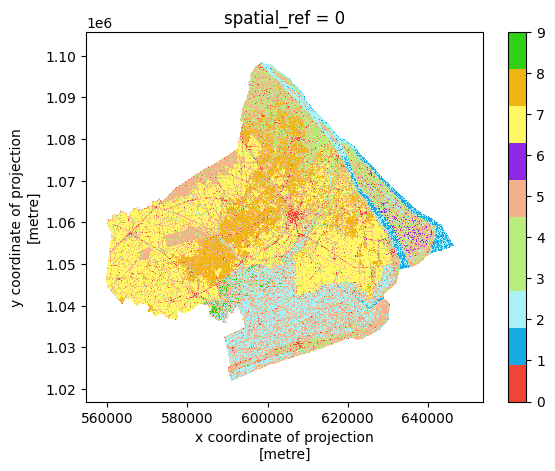

In [43]:
cmap = ListedColormap(colors)
region_result.plot(cmap=cmap)

In [44]:
label_mapping

{'Water1': 2,
 'Water': 1,
 'Urban1': 0,
 'tomlua': 9,
 'rice12': 8,
 'rice11': 7,
 'mia': 6,
 'cln1': 5,
 'cln': 4,
 'chn1': 3}

In [50]:
region_result.rio.to_raster("output_file.tif")

In [29]:
client.close()
cluster.close()